In [51]:
import math
import os
import random
import torch
from d2l import torch as d2l
import numpy as np

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'


'# sentences: 42069'

In [4]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [5]:
vocab.unk

0

In [56]:
def subsample(sentences, vocab):
    
    list_sentences = []
    for line in sentences:
        for token in line:
            if (vocab[token] != vocab.unk):
                list_sentences.append(token)
    counter = Counter(list_sentences)
    
    num_tokens = sum(counter.values())
    def keep(token):
        return (random.uniform(0, 1) < math.sqrt((1e-4)/counter[token]*num_tokens))
    return [[token for token in line if vocab[token] != vocab.unk and keep(token)] for line in sentences], counter

sub, counter = subsample(sentences, vocab)

(array([4.200e+02, 1.247e+03, 2.298e+03, 2.093e+03, 4.191e+03, 4.709e+03,
        4.910e+03, 3.265e+03, 4.525e+03, 4.062e+03, 3.279e+03, 1.649e+03,
        1.825e+03, 1.308e+03, 6.150e+02, 6.730e+02, 3.790e+02, 2.210e+02,
        1.180e+02, 9.600e+01, 7.400e+01, 4.000e+01, 2.200e+01, 1.100e+01,
        9.000e+00, 9.000e+00, 7.000e+00, 5.000e+00, 5.000e+00, 4.000e+00]),
 array([ 0.        ,  2.73333333,  5.46666667,  8.2       , 10.93333333,
        13.66666667, 16.4       , 19.13333333, 21.86666667, 24.6       ,
        27.33333333, 30.06666667, 32.8       , 35.53333333, 38.26666667,
        41.        , 43.73333333, 46.46666667, 49.2       , 51.93333333,
        54.66666667, 57.4       , 60.13333333, 62.86666667, 65.6       ,
        68.33333333, 71.06666667, 73.8       , 76.53333333, 79.26666667,
        82.        ]),
 <BarContainer object of 30 artists>)

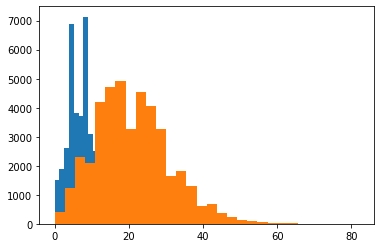

In [57]:
plt.hist([len(x) for x in sub], bins=30)
plt.hist([len(x) for x in sentences], bins=30)

In [59]:
def compare_count(token):
    return (sum(l.count(token) for l in sub), sum(l.count(token) for l in sentences))
compare_count('the')

(2053, 50770)

In [58]:
corpus = [vocab[line] for line in sub]

In [26]:
corpus[:3]

[[], [392, 2115], [140, 5277, 3054, 1580]]

In [23]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    
    for line in corpus:
        if (len(line) < 2):
            continue
        centers += line
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indicies = list(range(
                max(0, i - window_size),
                min(len(line), i + window_size + 1)
            ))
            indicies.remove(i)
            contexts.append([line[idx] for idx in indicies])
    return centers, contexts

In [24]:
# corpus = [list(range(7)), list(range(7, 10))]
# centers, contexts = get_centers_and_contexts(corpus, 2)
# for c, ct in zip(centers, contexts):
#     print(f'center {c} has context {ct}')

center 0 has context [1, 2]
center 1 has context [0, 2, 3]
center 2 has context [1, 3]
center 3 has context [1, 2, 4, 5]
center 4 has context [2, 3, 5, 6]
center 5 has context [3, 4, 6]
center 6 has context [5]
center 7 has context [8]
center 8 has context [7, 9]
center 9 has context [8]


In [28]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1500164'

In [36]:
class RandomGenerator:
    def __init__(self, sampling_weights):
#         sampling_weights can be unnormalized distribution
        self.population = list(range(1, len(sampling_weights) + 1)) # ignore unk token
        self.sampling_weights = sampling_weights 
        # for cache
        self.candidates = []
        self.i = 0
    def draw(self):
        if self.i == len(self.candidates):
            # redraw after use all of candidates
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [37]:
gen = RandomGenerator([1, 2, 3])
[gen.draw() for _ in range(10)]

[3, 3, 3, 3, 2, 1, 2, 3, 1, 3]

In [43]:
def get_negatives(all_contexts, vocab, counter, K):
    sampling_weights = [counter[vocab.to_tokens(i)] for i in range(1, len(vocab))]
    gen = RandomGenerator(sampling_weights)
    all_negatives = []
    
    for context in all_contexts:
        negatives = []
        while len(negatives) < len(context) * K:
            neg_idx = gen.draw()
            if (neg_idx not in context):
                negatives.append(neg_idx)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [46]:
all_negatives[0], all_contexts[0]

([179, 2136, 2, 18, 178], [2115])

In [52]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, context_negatives, masks, labels = [], [], [], []
    
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        context_negatives += [context + negative + [0]*(max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return np.array(centers).reshape((-1, 1)), np.array(context_negatives), np.array(masks), np.array(labels)

In [53]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = [[1]
 [1]]
contexts_negatives = [[2 2 3 3 3 3]
 [2 2 2 3 3 0]]
masks = [[1 1 1 1 1 1]
 [1 1 1 1 1 0]]
labels = [[1 1 0 0 0 0]
 [1 1 1 0 0 0]]


In [60]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, vocab, counter,
                                  num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                            collate_fn=batchify,
                                            num_workers=num_workers)
    return data_iter, vocab


In [61]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: (512, 1)
contexts_negatives shape: (512, 60)
masks shape: (512, 60)
labels shape: (512, 60)
